<a href="https://colab.research.google.com/github/patil-yasshh/projects/blob/main/stockmarket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

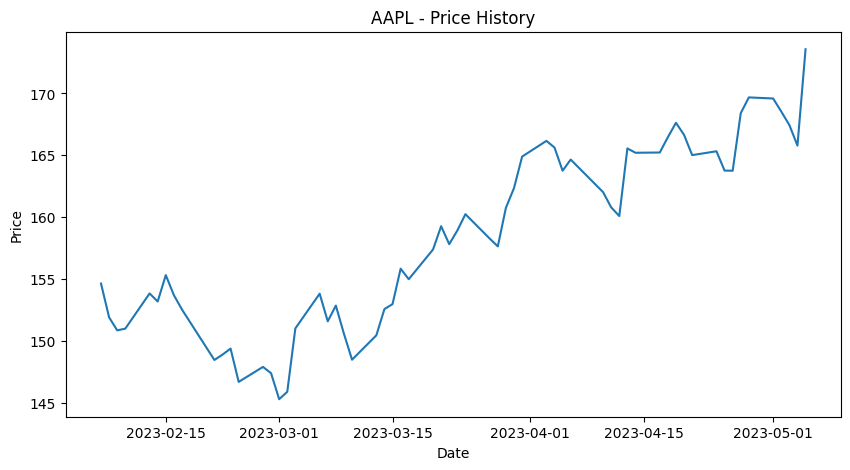

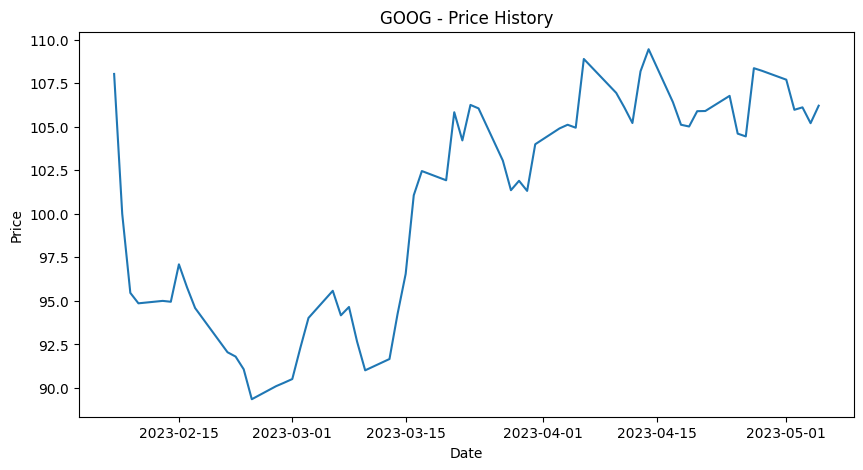

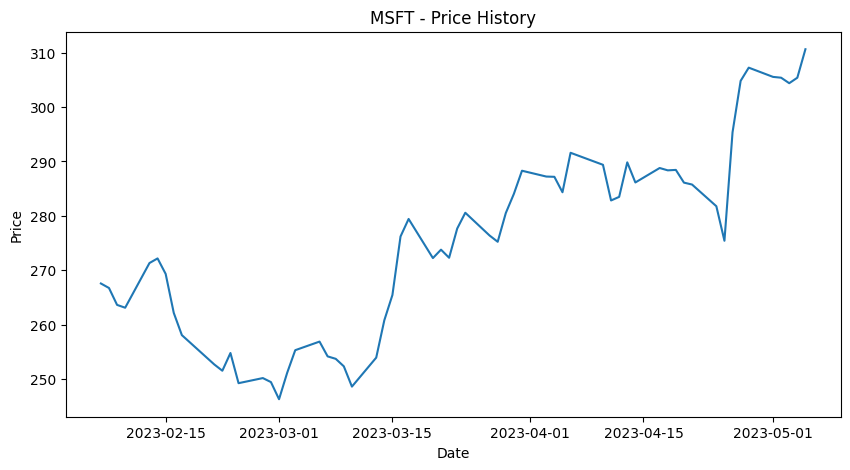

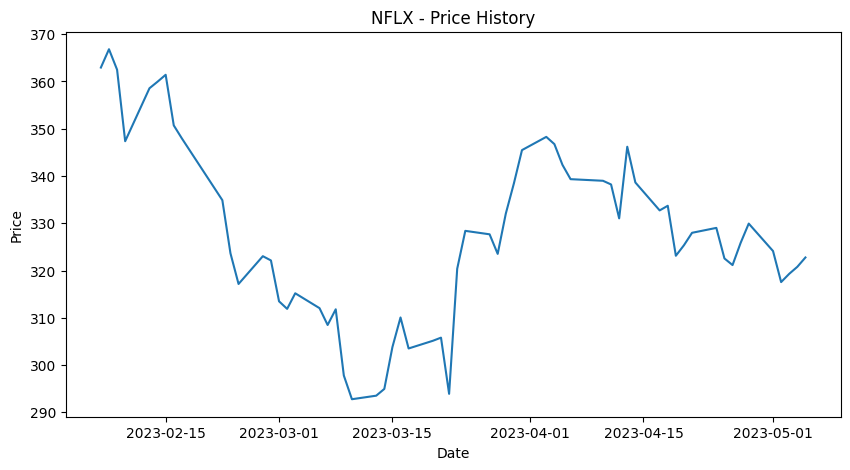

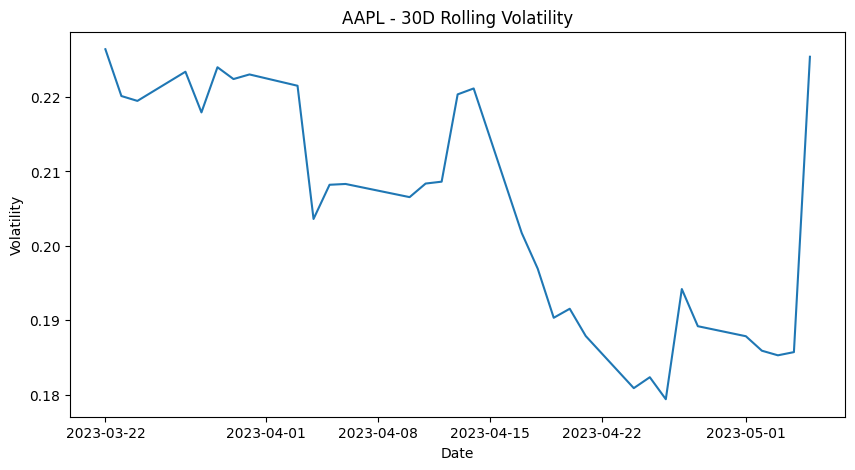

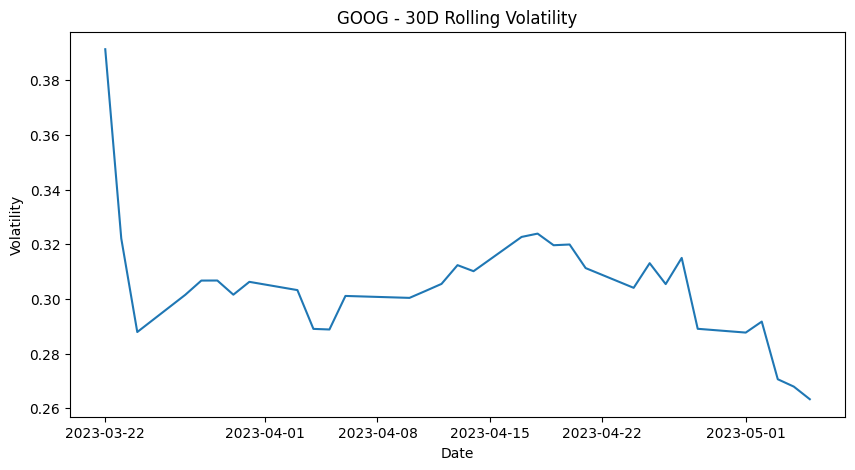

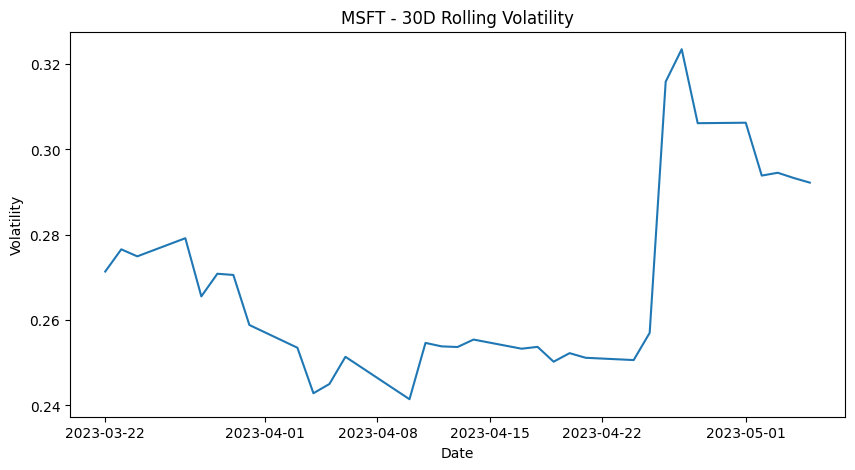

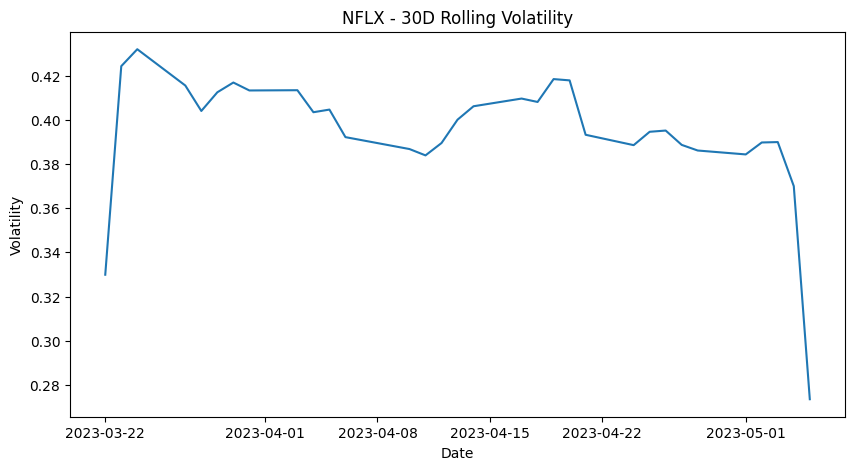

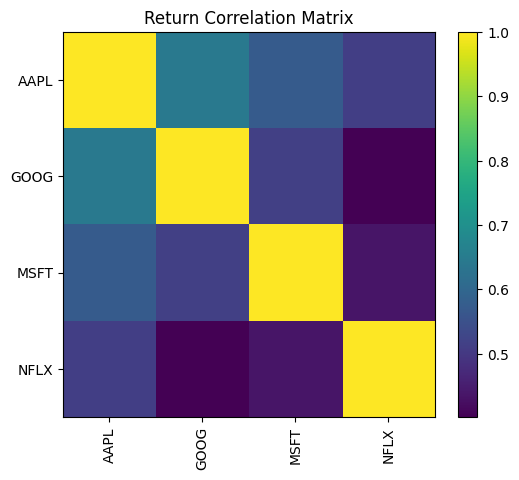

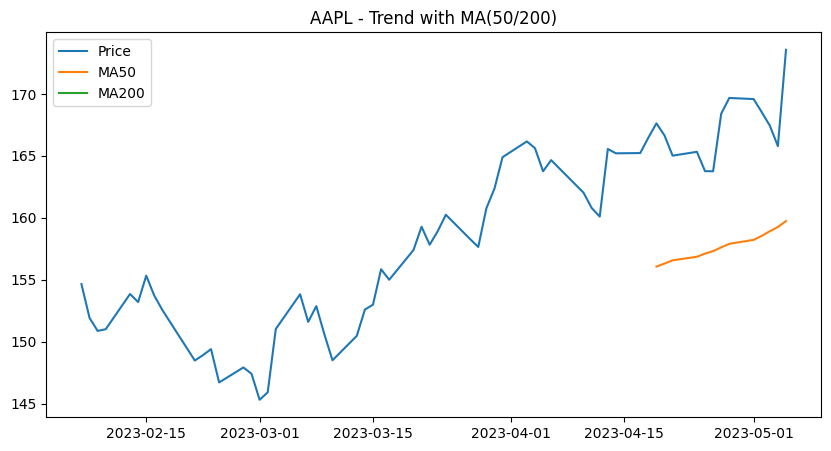

MAE: 0.01272643433440181
R2: 0.06385383396732569


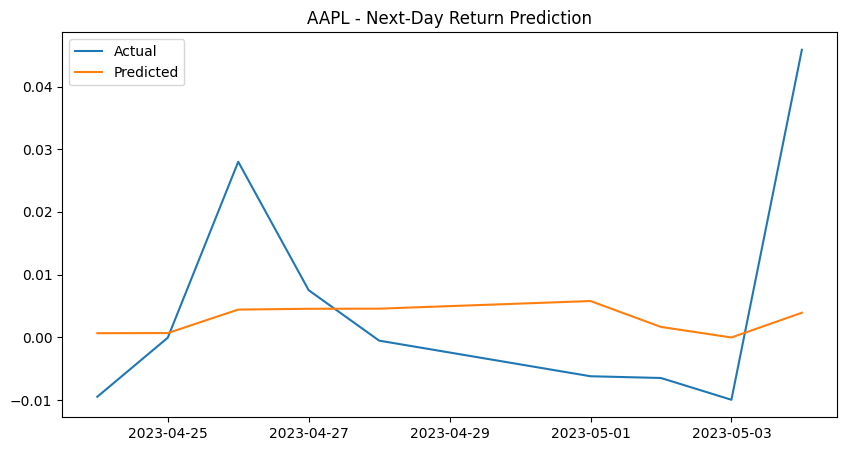


Next 10-day forecast:
         Date  AAPL_ForecastPrice
0 2023-05-06          174.581512
1 2023-05-07          175.369587
2 2023-05-08          176.264273
3 2023-05-09          177.256839
4 2023-05-10          177.908685
5 2023-05-11          178.518092
6 2023-05-12          179.140954
7 2023-05-13          179.827124
8 2023-05-14          180.461387
9 2023-05-15          181.060594


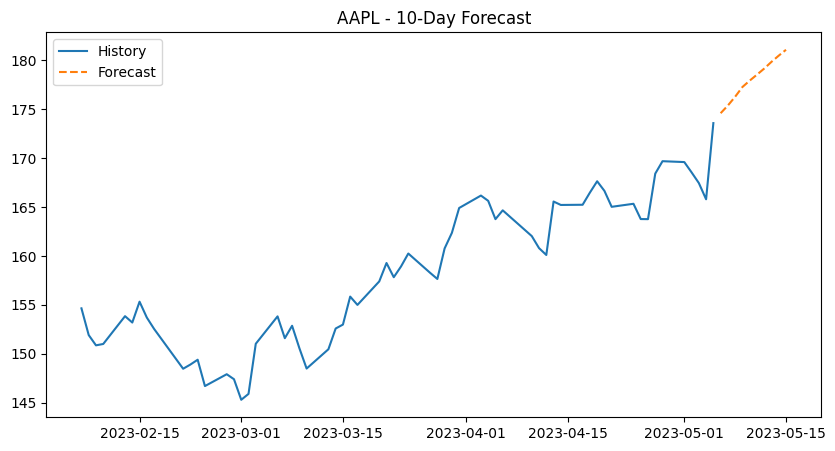

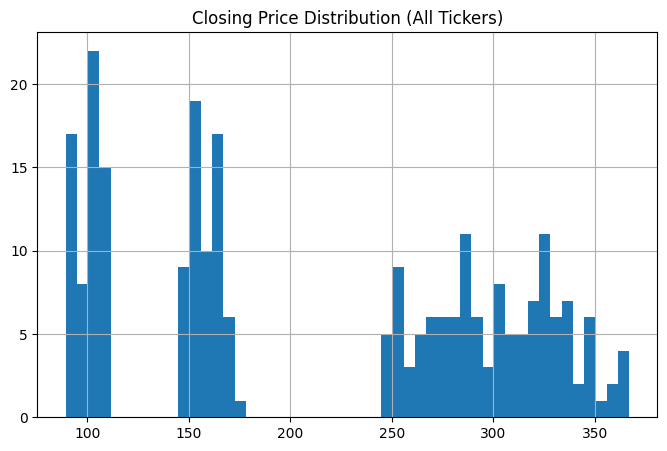

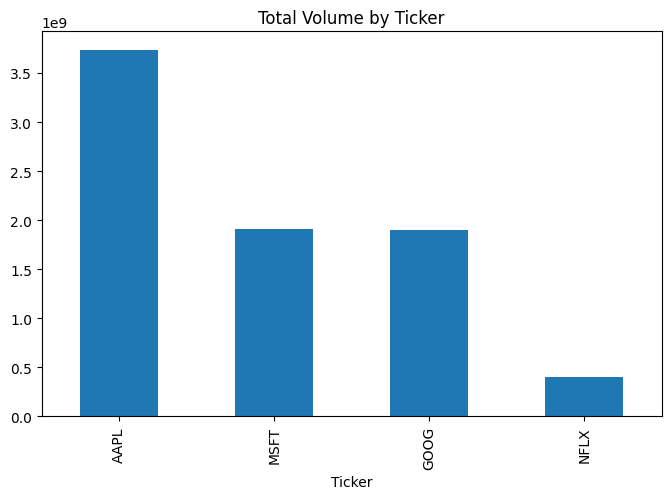

<Figure size 800x500 with 0 Axes>

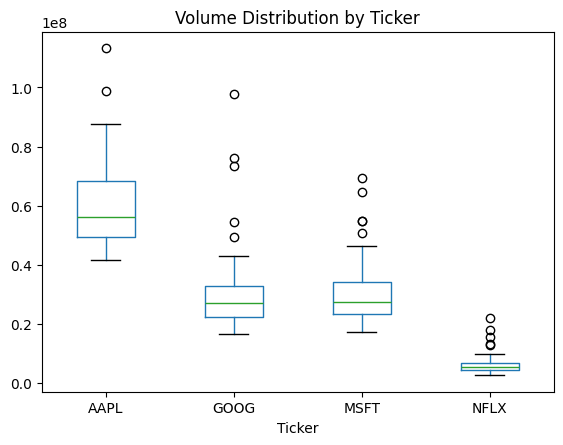

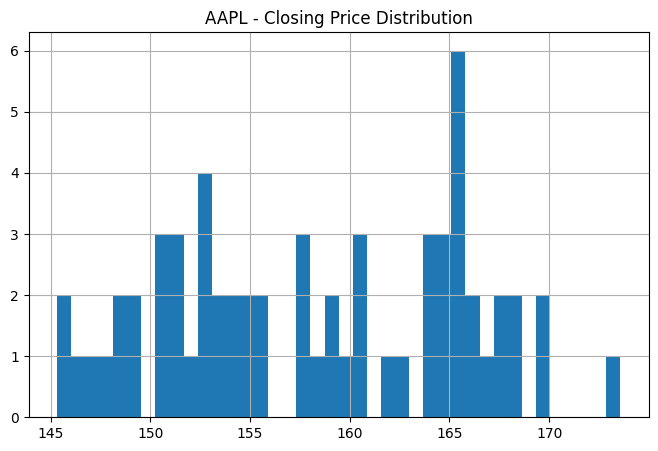

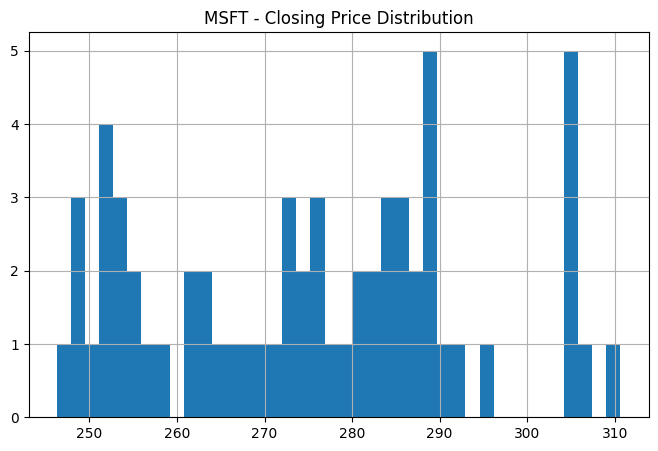

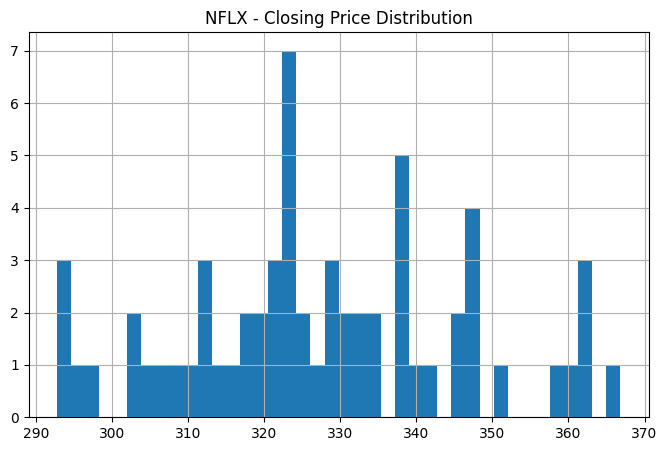

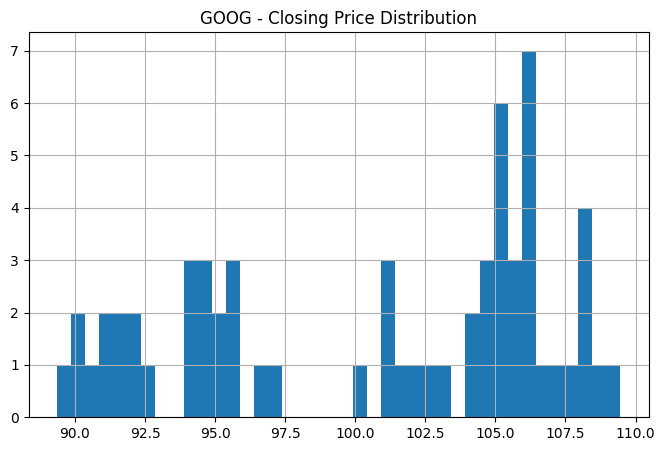

In [ ]:
# Stockmarket_analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Load data

file_path = "stocks.csv"
raw = pd.read_csv(file_path)

cols_lower = {c: str(c).lower() for c in raw.columns}
date_col = next((c for c in raw.columns if "date" in cols_lower[c]), raw.columns[0])
ticker_col = next((c for c in raw.columns if cols_lower[c] in ["ticker", "symbol"]), None)
close_col = next((c for c in raw.columns if "close" in cols_lower[c]), None)
volume_col = next((c for c in raw.columns if "volume" in cols_lower[c]), None)

raw[date_col] = pd.to_datetime(raw[date_col])

if ticker_col and close_col:
    df = raw[[date_col, ticker_col, close_col]].copy()
    df.rename(columns={date_col: "Date", ticker_col: "Ticker", close_col: "Close"}, inplace=True)
    pivot = df.pivot_table(index="Date", columns="Ticker", values="Close").sort_index()
else:
    df = raw.copy()
    df.rename(columns={date_col: "Date"}, inplace=True)
    pivot = df.set_index("Date").sort_index()

pivot = pivot.ffill().dropna(how="all")


# 2. Market trend analysis

returns = np.log(pivot / pivot.shift(1)).dropna()

for col in pivot.columns[:4]:
    plt.figure(figsize=(10, 5))
    plt.plot(pivot.index, pivot[col])
    plt.title(f"{col} - Price History")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

rolling_vol = returns.rolling(30).std() * np.sqrt(252)
for col in rolling_vol.columns[:4]:
    plt.figure(figsize=(10, 5))
    plt.plot(rolling_vol.index, rolling_vol[col])
    plt.title(f"{col} - 30D Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.show()

# Correlation heatmap
corr = returns.corr()
plt.figure(figsize=(6, 5))
im = plt.imshow(corr.values, aspect="auto")
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.title("Return Correlation Matrix")
plt.colorbar(im)
plt.show()

# Moving averages for first ticker
tkr = pivot.columns[0]
ma50 = pivot[tkr].rolling(50).mean()
ma200 = pivot[tkr].rolling(200).mean()
plt.figure(figsize=(10, 5))
plt.plot(pivot.index, pivot[tkr], label="Price")
plt.plot(ma50.index, ma50, label="MA50")
plt.plot(ma200.index, ma200, label="MA200")
plt.title(f"{tkr} - Trend with MA(50/200)")
plt.legend()
plt.show()

# 3. Machine Learning Prediction

target_ticker = "AAPL" if "AAPL" in pivot.columns else pivot.columns[0]
feat = pd.DataFrame(index=pivot.index)
feat["ret"] = returns[target_ticker]

for lag in range(1, 6):
    feat[f"lag_{lag}"] = feat["ret"].shift(lag)

feat["ma_5"] = pivot[target_ticker].rolling(5).mean().pct_change()
feat["ma_20"] = pivot[target_ticker].rolling(20).mean().pct_change()
feat["vol_10"] = returns[target_ticker].rolling(10).std()
feat["vol_20"] = returns[target_ticker].rolling(20).std()

others = [c for c in returns.columns if c != target_ticker]
if others:
    feat["mkt_ret"] = returns[others].mean(axis=1)

feat = feat.dropna()

y = feat["ret"].shift(-1).dropna()
X = feat.loc[y.index].drop(columns=["ret"])

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title(f"{target_ticker} - Next-Day Return Prediction")
plt.legend()
plt.show()

# 4. Forecast next 10 days

N = 10
last_row = feat.iloc[[-1]].copy()
last_price = pivot[target_ticker].iloc[-1]

future_dates, future_prices = [], []
current_price = last_price

for i in range(N):
    X_row = last_row.drop(columns=["ret"], errors="ignore")
    pred_ret = rf.predict(X_row)[0]
    current_price *= np.exp(pred_ret)
    future_prices.append(current_price)
    next_date = pivot.index[-1] + timedelta(days=i+1)
    future_dates.append(next_date)
    # shift lag features
    for lag in range(5, 1, -1):
        if f"lag_{lag}" in last_row.columns:
            last_row[f"lag_{lag}"] = last_row.get(f"lag_{lag-1}", last_row[f"lag_{lag}"])
    if "lag_1" in last_row.columns:
        last_row["lag_1"] = pred_ret

forecast = pd.DataFrame({"Date": future_dates, f"{target_ticker}_ForecastPrice": future_prices})
print("\nNext 10-day forecast:\n", forecast)

plt.figure(figsize=(10, 5))
plt.plot(pivot.index[-100:], pivot[target_ticker].iloc[-100:], label="History")
plt.plot(forecast["Date"], forecast[f"{target_ticker}_ForecastPrice"], label="Forecast", linestyle="--")
plt.title(f"{target_ticker} - 10-Day Forecast")
plt.legend()
plt.show()


# 5. Volume and Closing Price Analysis

if close_col:
    plt.figure(figsize=(8, 5))
    raw[close_col].dropna().hist(bins=50)
    plt.title("Closing Price Distribution (All Tickers)")
    plt.show()

if ticker_col and volume_col:
    vol_by_ticker = raw.groupby(ticker_col)[volume_col].sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    vol_by_ticker.plot(kind="bar")
    plt.title("Total Volume by Ticker")
    plt.show()

    plt.figure(figsize=(8, 5))
    raw.boxplot(column=volume_col, by=ticker_col, grid=False)
    plt.title("Volume Distribution by Ticker")
    plt.suptitle("")
    plt.show()

# Closing price distribution per ticker
if ticker_col and close_col:
    for tkr in raw[ticker_col].unique():
        plt.figure(figsize=(8, 5))
        raw.loc[raw[ticker_col] == tkr, close_col].dropna().hist(bins=40)
        plt.title(f"{tkr} - Closing Price Distribution")
        plt.show()
